# Lab 4
We will first attempt to implement the algorithm that is found in the paper. The
DQL that we will be working on uses 2 methods (1) Experience replay and (2)
Fixed target network to introduce efficient use of expeiences and stability in
training.

In [ ]:
%%bash
pip3 install gymnasium[classic_control]

In [1]:
%%bash
export MPS_ENABLE=1

In [7]:
import gymnasium as gym
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

env = gym.make("MountainCar-v0")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=500)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cpu")

We’ll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

In [8]:
import random
import operator

class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.
        https://en.wikipedia.org/wiki/Segment_tree
        Can be used as regular array, but with two
        important differences:
            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient ( O(log segment size) )
               `reduce` operation which reduces `operation` over
               a contiguous subsequence of items in the array.
        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must form a mathematical group together with the set of
            possible values for array elements (i.e. be associative)
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.
            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))
        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences
        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum
        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.
        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix
        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        try:
            assert 0 <= prefixsum <= self.sum() + 1e-5
        except AssertionError:
            print("Prefix sum error: {}".format(prefixsum))
            exit()
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)

In [9]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','terminated'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class PrioritizedReplayMemory(object):
    def __init__(self, size, alpha=0.6, beta_start=0.4, beta_frames=100000):
        super(PrioritizedReplayMemory, self).__init__()
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

        assert alpha >= 0
        self._alpha = alpha

        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame=1

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def beta_by_frame(self, frame_idx):
        return min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)

    def push(self, *args):
        data = Transition(*args)
        idx = self._next_idx

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize


        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _encode_sample(self, idxes):
        return [self._storage[i] for i in idxes]
    def __len__(self):
        return len(self._storage)
    def _sample_proportional(self, batch_size):
        res = []
        for _ in range(batch_size):
            mass = random.random() * self._it_sum.sum(0, len(self._storage) - 1)
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size):
        idxes = self._sample_proportional(batch_size)

        weights = []

        #find smallest sampling prob: p_min = smallest priority^alpha / sum of priorities^alpha
        p_min = self._it_min.min() / self._it_sum.sum()

        beta = self.beta_by_frame(self.frame)
        self.frame+=1
        
        #max_weight given to smallest prob
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = torch.tensor(weights, device=device, dtype=torch.float) 
        encoded_sample = self._encode_sample(idxes)
        return encoded_sample

    def update_priorities(self, idxes, priorities):
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = (priority+1e-5) ** self._alpha
            self._it_min[idx] = (priority+1e-5) ** self._alpha

            self._max_priority = max(self._max_priority, (priority+1e-5))

class Network(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.hidden_nodes = 64
        self.layer1 = nn.Linear(n_observations, self.hidden_nodes)
        self.layer2 = nn.Linear(self.hidden_nodes, self.hidden_nodes)
        self.layer4 = nn.Linear(self.hidden_nodes, n_actions)
        
        nn.init.kaiming_normal_(self.layer1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.layer2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.layer4.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        """Forward feed neural network call
        
        When called with x as a element, determine next action.
        
        When called with x as a batch, return tensor([[left0exp,right0exp]...]).

        :param x: Input to learn
        :type x: tensor
        :return: 
        :rtype: tensor
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer4(x)
    
class Duelnet(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_observations, 128) 
        self.A_head = torch.nn.Linear(128, n_actions)
        self.V_head = torch.nn.Linear(128, 1)

    def forward(self, x):
        A = self.A_head(F.relu(self.fc1(x)))
        V = self.V_head(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q(s,a)=V(s)+A(s,a)-mean(A(s,a))
        return Q

In [10]:
class DQN():
    """Base DQL class"""
    BATCH_SIZE = 64 # BATCH_SIZE is the number of transitions sampled from the replay buffer
    GAMMA = 0.99 # GAMMA is the discount factor
    LR = 0.0005 # LR is the learning rate of the ``Adam`` optimizer
    REPLAY_CAPACITY = 2000 # REPLAY_CAPACITY is the maximum capacity of the replay buffer
    MAX_RUN_WITH_GPU = 500 # MAX_RUN_WITH_GPU is the maximum number of runs with GPU
    MAX_RUN_WITH_CPU = 100 # MAX_RUN_WITH_CPU is the maximum number of runs with CPU
    C_STEP_RESET = 10 # C_STEP_RESET is the number of steps before update to target net
    EPSILON_START = 1.0
    EPSILON_DECAY = 2000
    EPSILON_END = 0.05
    
    def __init__(self):
        # Get number of actions from gym action space
        n_actions = env.action_space.n
        # Get the number of state observations
        state, info = env.reset()
        n_observations = len(state)
        self.episode_durations = []
        self.epsilon = DQN.EPSILON_START
        
        """Initialize replay memory D to capacity N"""
        self.memory = ReplayMemory(DQN.REPLAY_CAPACITY) 
        """Initialize action-value function Q with random weights $\theta$"""
        self.policy_net = Network(n_observations, n_actions)
        """Initialize target action-value function \hat Q with weights $\theta^-$"""
        self.target_net = Network(n_observations, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=DQN.LR)
        self.loss_func = nn.SmoothL1Loss()
    def select_action(self, state: torch.tensor) -> torch.tensor:
        """With probability epsilon select a random action
        otherwise select $a = \arg\max_a Q(s, a)$
        """
        if random.random() < self.epsilon:
            # take optmal action
            with torch.no_grad():
                return torch.argmax(self.policy_net(state)).view(1,1)
        else:
            # take a random action (exploration)
            return torch.tensor([[env.action_space.sample()]],
                                device=device, dtype=torch.int64)
    def plot_durations(self,show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())
    def optimize_model(self):
        if len(self.memory) < DQN.BATCH_SIZE:
            return
        transitions = self.memory.sample(DQN.BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        non_final_next_states = torch.tensor([1 if s is False else 0 for s in batch.terminated]).unsqueeze(1)
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward).unsqueeze(1)
        next_state_batch = torch.cat(batch.next_state)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        with torch.no_grad():
            next_state_values = self.target_net(next_state_batch).max(1).values
        # Compute the expected Q values
        expected_state_action_values = next_state_values * DQN.GAMMA * non_final_next_states + reward_batch
    
        loss = self.loss_func(state_action_values, expected_state_action_values)

        """Perform gradient descent with respect to network parameters"""
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    def start(self, env, num_episode_manual=0):
        if torch.cuda.is_available():
            num_episodes = DQN.MAX_RUN_WITH_GPU
        else:
            num_episodes = DQN.MAX_RUN_WITH_CPU
        num_episodes = num_episode_manual if num_episode_manual > 0 else num_episodes

        for _ in range(num_episodes):
            # Initialize the environment and get its state
            state, _ = env.reset()
            state = torch.tensor(state,
                                 dtype=torch.float32,
                                 device=device).unsqueeze(0)
            for t in count():
                """With probability select a random action a_t"""
                action = self.select_action(state)
                """Execute action a_t in emulator and observe reward r_t"""
                observation, reward, terminated, truncated, _ = env.step(action.item())
                reward = torch.tensor([reward], device=device)
                done = terminated or truncated
                next_state = torch.tensor(observation,
                                        dtype=torch.float32,
                                        device=device).unsqueeze(0)

                """Store transition (s_t, a_t, s_{t+1}, r_t) in D"""
                self.memory.push(state, action, next_state, reward, terminated)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                self.optimize_model()
                self.epsilon = (self.epsilon - self.EPSILON_END) * np.exp(- 1 / self.EPSILON_DECAY) + self.EPSILON_END

                """Every C steps reset \hat Q = Q"""
                if t % DQN.C_STEP_RESET == 0:
                    self.target_net.load_state_dict(self.policy_net.state_dict())

                if done:
                    self.episode_durations.append(t + 1)
                    self.plot_durations()
                    break
        print('Complete')
        self.plot_durations(show_result=True)
        plt.ioff()
        plt.show()
     
class DoubleDQN(DQN):
    """Double DQL class
    Tackles the problem of overestimation of Q-values.
    """
    def optimize_model(self):
        if len(self.memory) < DQN.BATCH_SIZE:
            return
        transitions = self.memory.sample(DQN.BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.tensor([1 if s is False else 0 for s in batch.terminated]).unsqueeze(1)
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward).unsqueeze(1)
        next_state_batch = torch.cat(batch.next_state)

        # Get the policy net Q value
        state_action_values = self.policy_net(state_batch).gather(1, action_batch) # Q(s,a)
        
        # Get max action of target network
        max_action = self.policy_net(next_state_batch).max(1,keepdim=True).indices
        with torch.no_grad():
            next_state_values = self.target_net(next_state_batch).gather(1, max_action)
        # Compute the expected Q values
        expected_state_action_values = next_state_values * DQN.GAMMA * non_final_next_states + reward_batch
        
        loss = self.loss_func(state_action_values, expected_state_action_values)

        """Perform gradient descent with respect to network parameters"""
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
class DuelingDQN(DQN):
    def __init__(self):
        super().__init__()
        # Get number of actions from gym action space
        n_actions = env.action_space.n
        # Get the number of state observations
        state, info = env.reset()
        n_observations = len(state)
        
        """Initialize action-value function Q with random weights $\theta$"""
        self.policy_net = Duelnet(n_observations, n_actions).to(device)
        """Initialize target action-value function \hat Q with weights $\theta^-$"""
        self.target_net = Duelnet(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
class DoubleDuelingDQN(DuelingDQN, DoubleDQN):
    def optimize_model(self):
        DoubleDQN.optimize_model(self)

class PrioritizedDQN(DQN):
    def __init__(self):
        super().__init__()
        self.memory = PrioritizedReplayMemory(DQN.REPLAY_CAPACITY) 

In [11]:
simple_dqn = DQN()
double_dqn = DoubleDQN()
# dueling_dqn = DuelingDQN()
# double_dueling_dqn = DoubleDuelingDQN()
# prioritised_dqn = PrioritizedDQN()

Complete


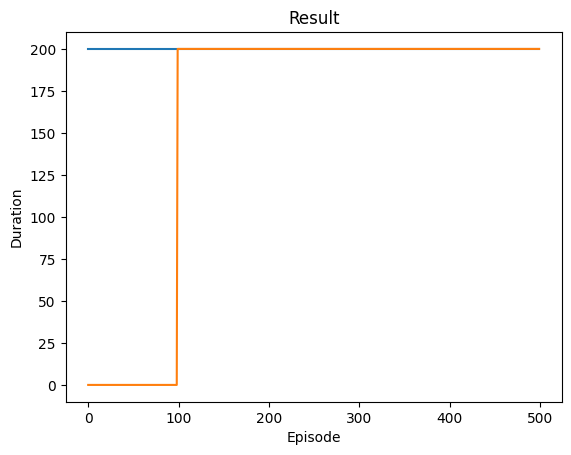

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
env = gym.make("MountainCar-v0")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=500)
double_dqn.start(env,500)

In [127]:
transitions = double_dqn.memory.sample(DQN.BATCH_SIZE)
# Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
# detailed explanation). This converts batch-array of Transitions
# to Transition of batch-arrays.
batch = Transition(*zip(*transitions))

# Compute a mask of non-final states and concatenate the batch elements
# (a final state would've been the one after which simulation ended)
non_final_next_states = torch.tensor([1 if s is False else 0 for s in batch.terminated]).unsqueeze(1)
state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward).unsqueeze(1)
next_state_batch = torch.cat(batch.next_state)

# Get the policy net Q value
state_action_values = double_dqn.policy_net(state_batch).gather(1, action_batch) # Q(s,a)

# Get max action of target network
max_action = double_dqn.policy_net(next_state_batch).max(1).indices.view(-1, 1)
with torch.no_grad():
    next_state_values = double_dqn.target_net(next_state_batch).gather(1, max_action)
# Compute the expected Q values
expected_state_action_values = next_state_values * DQN.GAMMA * non_final_next_states + reward_batch

loss = double_dqn.loss_func(state_action_values, expected_state_action_values)

"""Perform gradient descent with respect to network parameters"""
# Optimize the model
double_dqn.optimizer.zero_grad()
loss.backward()
double_dqn.optimizer.step()

In [141]:

state, _ = env.reset()
state = torch.tensor(state,
                        dtype=torch.float32,
                        device=device).unsqueeze(0)
a = double_dqn.select_action(state)

In [143]:
a.item()

1